# Credit Card Loan Default Prediction
## Author: Uriel Yang, Xinman Zhang

### Table of Contents

* [1 Introduction](#1)
    * [1.1 Motivation](#1.1)
    * [1.2 Goal](#1.2)
    * [1.3 Data Source](#1.3)
    * [1.4 Literature Review](#1.4)
* [2 Data Exploration](#2)
    * [2.1 Loading Required Packages](#2.1)
    * [2.2 Loading Datasets](#2.2)
    * [2.3 Dataset overview](#2.3)
* [3 Feature Selection](#3)
    * [3.1 Drop features with no meaning](#3.1)
    * [3.2 Drop features with missing values > 10%](#3.2)
    * [3.3 Drop highly-correlated features](#3.3)
        * [3.3.1 Drop features whose VIF > 10](#3.3.1)
        * [3.3.2 Drop features whose correlatioin > 0.75](#3.3.2)
    * [3.4 Feature selection summary](#3.4)
* [4 Handling Missing Values](#4)
    * [4.1 Create dichotomous dummy variable](#4.1)
    * [4.2 Replace missing values](#4.2)
        * [4.2.1 Replace missing values for object type](#4.2.1)
        * [4.2.2 Replace missing values for int type](#4.2.2)
        * [4.2.3 Replace missing values for float type](#4.2.3)
* [5 Introduce New Variables](#5)
    * [5.1 Introduce probability by income](#5.1)
    * [5.2 Introduce previously approved probability](#5.2)
* [6 Prepare for Training](#6)
    * [6.1 Extract $X$ and $y$](#6.1)
    * [6.2 Split the train-test sets](#6.2)
    * [6.3 Normalization](#6.3)
* [7 Check PCA](#7)
* [8 Treating Imbalanced Data](#8)
    * [8.1 K-NN under-sampling](#8.1)
    * [8.2 Random Over-Sampling](#8.2)
* [9 Loss Function and Build the Models](#9)
    * [9.1 Logistic regression model](#9.1)
    * [9.2 Random forest model](#9.2)
* [10 Evaluation](#10)
    * [10.1 Evaluate logistic regression model](#10.1)
    * [10.2 Evaluate random forest model](#10.2)
* [11 Feature Importance](#11)
* [12 Comparing with the model without feature engineering or treating imbalance](#12)
* [13 Conclusion](#13)

## 1 Introduction <a class="anchor" id="1"></a>
### 1.1 Motivation <a class="anchor" id="1.1"></a>
For banking and financial companies to succeed, it is important for them to assess the risk of losing money before lending to customers. More specifically, given the background information of a customer, a credit card issuing bank would like to predict if the client will have difficulty in making timely payments to his or her credit card installments. In this way, the company can make more prudent decisions on whether or not to sanction the loan to a client, and thus minimize the potential loss. 

### 1.2 Goal <a class="anchor" id="1.2"></a>

In this project, we will develop a model based on clients' information (personal backgrounds and past payment records). With the features provided in data, we hope our model will accurately predict loan defaults. Further, based on our predictions, we also expect to find the driving factors behind the loan defaults (i.e. the features which are strong indicators of a loan default). In this way, credit card issuing banks can utilize this knowledge for their risk assessments.

### 1.3 Data Source <a class="anchor" id="1.3"></a>
The dataset “Credit Card Fraud Detection” is collected from Kaggle competition. Here is the link to the dataset. https://www.kaggle.com/mishra5001/credit-card. There are three tables in the dataset, including application data, columns data, and previous application data. In this project, we will make use of  application data, with columns data as a supplementary to explain the meanings of different features.

### 1.4 Liteartue Review <a class="anchor" id="1.4"></a>

Since the dataset is collected from Kaggle competition, we've reviewed some existing approaches that competitors took. Here is one example. https://www.kaggle.com/nareshbhat/fraud-detection-feature-selection-over-sampling

* To deal with the highly imbalanced data in this dataset, some competitors used random over-sampling to increase the minority group. While this is a general approach to compensate for the imbalance, we decide to use a combination of random over-sampling and k-NN based under-sampling to see if it can produce higher accuracy. Details about our approaches will be discussed in section 8.1.
* Some previous competitors used univariate selection to find the highest score and select the best features. While this approach technically works, the results they got are not decent. The scores are generally low. Also, univariate selection is generally performed before training as a preprocessing step, so we think it's inappropriate to perform that after training to select driving factors. Instead, we use feature importance. Details about our approach will be discussed in section 11.
* Evaluation metrics used by previous competitors include accuracy, precision, recall, and f1 score. Given the fact that our dataset is highly imbalanced, we believe that not all of those evaluation metrics are suitable for our model. Details about our evaluation strategy will be discussed in section 10.


## 2 Data Exploration <a class="anchor" id="2"></a>
### 2.1 Loading required packages <a class="anchor" id="2.1"></a>

In [4]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
from sklearn.impute import KNNImputer
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.decomposition import PCA

### 2.2 Loading datasets <a class="anchor" id="2.2"></a>
Load application data and previous application data.

In [5]:
# Datasets directory
application_data = 'dataset/application_data.csv'
previous_data = 'dataset/previous_application.csv'

# Read the application dataset
df = pd.read_csv(application_data)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Then we read the previous application dataset. To better interpret the dataset, we sort it by SK_ID_CURR, which is the key in application dataset. We can see from the head that some of the SK_ID_CURR has only one previous record, while others have more than one previous records.

In [6]:
# Read the previous application dataset
pre_df = pd.read_csv(previous_data)
pre_df.sort_values(by=['SK_ID_CURR'])

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
201668,1369693,100001,Consumer loans,3951.000,24835.5,23787.0,2520.0,24835.5,FRIDAY,13,...,Connectivity,8.0,high,POS mobile with interest,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,0.0
892077,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
575941,1810518,100003,Cash loans,98356.995,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
1021650,2636178,100003,Consumer loans,64567.665,337500.0,348637.5,0.0,337500.0,SUNDAY,17,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
1223745,2396755,100003,Consumer loans,6737.310,68809.5,68053.5,6885.0,68809.5,SATURDAY,15,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814647,1296007,456255,Cash loans,30737.655,765000.0,1067940.0,NaN,765000.0,FRIDAY,14,...,XNA,60.0,low_normal,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
214743,1743609,456255,Consumer loans,11090.835,102037.5,112815.0,0.0,102037.5,THURSDAY,18,...,Furniture,12.0,middle,POS industry with interest,365243.0,-960.0,-630.0,-690.0,-687.0,0.0
1411592,2729207,456255,Consumer loans,11514.555,58225.5,58545.0,5823.0,58225.5,FRIDAY,18,...,Connectivity,6.0,high,POS mobile with interest,365243.0,-469.0,-319.0,-409.0,-400.0,0.0
608510,2073384,456255,Cash loans,16400.610,229500.0,254340.0,NaN,229500.0,THURSDAY,12,...,XNA,24.0,middle,Cash X-Sell: middle,365243.0,-618.0,72.0,-558.0,-528.0,1.0


### 2.3 Dataset overview <a class="anchor" id="2.3"></a>
We will first perform some data exploration to better understand the dataset.

In application data, there are 307,511 rows and 122 columns, including 65 float types, 41 int types, and 16 object types. 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


<img src="feature type.jpeg" width="600">

In previous application data, there are 37 columns and 1,670,214 rows.

In [8]:
pre_df.shape

(1670214, 37)

The target variable of this dataset is whether or not the credit card loan is default. We will see the distribution of target variable.

In [9]:
# Data Exploration
print('Number of non-default: {}'.format((df['TARGET']==0).sum()))
print('Number of default: {}'.format((df['TARGET']==1).sum()))

Number of non-default: 282686
Number of default: 24825


<img src="default distribution.jpeg" width="600">

We can see that there is only 8% default, which is a pretty imbalanced dataset for classification problem. We will deal with that in later sections.

## 3 Feature Selection <a class="anchor" id="3"></a>
### 3.1 Drop features with no meaning <a class="anchor" id="3.1"></a>
There are some features in the dataset that have no meanings such as FLAG_DOCUMENT_1 and did client provide document n. In total, we drop 23 features with no meaning and keep the remaining 99 features.

Below are all the feature names to be dropped.

In [10]:
# Feature names to be dropped
df.iloc[:, np.r_[41:44,96:116]].columns

Index(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],
      dtype='object')

Then we drop all the features with no meaning.

In [11]:
# Drop features with no meaning
df = df.iloc[:, np.r_[0:41, 44:96, 116:122]]
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0.0,0.0,0.0,-273.0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0.0,6.0,0.0,-1909.0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,-322.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2 Drop features with missing values > 10% <a class="anchor" id="3.2"></a>
Features with too many missing values will largely impact our performance later. Therefore, we dropped all the features with more 10% missing values. We choose 10% as the threshold because we are doing KNNImputer later to replace missing values. Having too many missing values will largely increase the time to perform the KNNImputer.

Below is the table of percentage of missing values for each feature.

In [12]:
# Table of percentage of missing values for each feature
missing_perc = np.array(df.isna().mean().to_frame().iloc[:,0])
missing_perc

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.90229943e-05, 9.04032701e-04, 4.20147572e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.59908101e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.13455454e-01, 6.50383238e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.07497293e-01, 5.85159555e-01, 4.87810192e-01,
       6.64977838e-01, 6.98722973e-01, 5.32959797e-01, 5.03487680e-01,
       4.97608216e-01, 6.78486298e-01, 5.93767377e-01, 6.83549532e-01,
       5.01933264e-01, 6.94329634e-01, 5.51791643e-01, 5.07497293e-01,
      

Below is the distribution table of the percentage of missing values of all features.

In [13]:
# Data Exploration
missing_df = pd.DataFrame(missing_perc,columns=['missing'])
bins = [-1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
names = ['no', '<10%', '10-20%', '20-30%', '30-40%','40-50%','50-60%','60-70%','70-80%','80-90%','>90%']
missing_df['count'] = pd.cut(missing_df['missing'], bins, labels=names)
missing_df = missing_df.groupby(['count'])['count'].size()
missing_df

count
no        35
<10%       9
10-20%     6
20-30%     0
30-40%     1
40-50%     8
50-60%    23
60-70%    17
70-80%     0
80-90%     0
>90%       0
Name: count, dtype: int64

To visualize the percentage of missing values, we plot the histogram. We can see from the graph that a lot of features with more than 40% missing values.

<img src="missing values percentage.jpeg" width="800">


Here are indexes of features who have more than 10% missing values.

In [14]:
# feature index who has more than 10% missing values
drop_missing = np.where(missing_perc > 0.1)
drop_missing

(array([21, 28, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
        56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
        73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 93, 94,
        95, 96, 97, 98]),)

Then we drop all those features with more than 10% missing values.

In [15]:
df = df.drop(df.columns[drop_missing],axis = 1)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,Business Entity Type 3,2.0,2.0,2.0,2.0,-1134.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,School,1.0,0.0,1.0,0.0,-828.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,Government,0.0,0.0,0.0,0.0,-815.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,Business Entity Type 3,2.0,0.0,2.0,0.0,-617.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,1,1,Religion,0.0,0.0,0.0,0.0,-1106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,Services,0.0,0.0,0.0,0.0,-273.0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,XNA,0.0,0.0,0.0,0.0,0.0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,1,1,School,6.0,0.0,6.0,0.0,-1909.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,1,1,0,Business Entity Type 1,0.0,0.0,0.0,0.0,-322.0


### 3.3 Drop highly-correlated features <a class="anchor" id="3.3"></a>
In this project, we intend to build a logistic regression model later. Therefore, we cannot deal with multicollinearity. To solve this problem, we decide to remove all features that are highly correlated to ensure the performance of models.
#### 3.3.1 Drop features whose VIF > 10 <a class="anchor" id="3.3.1"></a>
We first calculate the variance inflation factor (VIF) of all int values and drop those whose VIF is greater than 10. 

Below is the table of VIF of all int features.

In [16]:
# table of VIF for all int features
vif_data = pd.DataFrame() 
vif_data["feature"] = df.select_dtypes('int').columns 
vif_data["VIF"] = [variance_inflation_factor(df.select_dtypes('int').values, i) for i in range(len(df.select_dtypes('int').columns))] 
vif_data = vif_data.sort_values(by="VIF", ascending=False) 
vif_data 

,feature,VIF
6,FLAG_MOBIL,14735.266590
7,FLAG_EMP_PHONE,11563.580280
4,DAYS_EMPLOYED,2486.530345
9,FLAG_CONT_MOBILE,535.478030
12,REGION_RATING_CLIENT,183.405699
13,REGION_RATING_CLIENT_W_CITY,181.933217
3,DAYS_BIRTH,27.835114
14,HOUR_APPR_PROCESS_START,16.202799
19,REG_CITY_NOT_WORK_CITY,9.731628
16,REG_REGION_NOT_WORK_REGION,9.518084


Then we find the feature index whose VIF is large than 10

In [17]:
# feature index whose VIF is larger than 10
vif_columns = vif_data[vif_data["VIF"]>10].iloc[:,0]
vif_columns 

6                      FLAG_MOBIL
7                  FLAG_EMP_PHONE
4                   DAYS_EMPLOYED
9                FLAG_CONT_MOBILE
12           REGION_RATING_CLIENT
13    REGION_RATING_CLIENT_W_CITY
3                      DAYS_BIRTH
14        HOUR_APPR_PROCESS_START
Name: feature, dtype: object

Then we drop all the features whose VIF > 10.

In [18]:
df = df.drop(vif_columns, axis = 1)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,Business Entity Type 3,2.0,2.0,2.0,2.0,-1134.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,School,1.0,0.0,1.0,0.0,-828.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,Government,0.0,0.0,0.0,0.0,-815.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,Business Entity Type 3,2.0,0.0,2.0,0.0,-617.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,1,1,Religion,0.0,0.0,0.0,0.0,-1106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,Services,0.0,0.0,0.0,0.0,-273.0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,XNA,0.0,0.0,0.0,0.0,0.0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,1,1,School,6.0,0.0,6.0,0.0,-1909.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,1,1,0,Business Entity Type 1,0.0,0.0,0.0,0.0,-322.0


#### 3.3.2 Drop features whose correlatioin > 0.75 <a class="anchor" id="3.3.2"></a>
Since the method of VIF can only check for int types, we also calculate the correlation between features, and drop those whose correlation is greater than 0.75.

Below is the correlation matrix.

In [19]:
# Create correlation matrix
corr_matrix = df.corr().abs()
corr_matrix

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
SK_ID_CURR,1.000000,0.002108,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.000973,0.000384,...,0.001097,0.002903,0.001885,0.001582,0.000067,0.001409,0.000082,0.001423,0.001187,0.000858
TARGET,0.002108,1.000000,0.019187,0.003982,0.030369,0.012817,0.039645,0.037227,0.041975,0.051457,...,0.006942,0.002819,0.044395,0.050994,0.032518,0.009131,0.032248,0.009022,0.031276,0.055218
CNT_CHILDREN,0.001129,0.019187,1.000000,0.012882,0.002145,0.021374,0.001827,0.025573,0.183395,0.028019,...,0.008185,0.014835,0.020072,0.070650,0.069957,0.015593,0.001262,0.015232,0.001861,0.005865
AMT_INCOME_TOTAL,0.001820,0.003982,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027805,0.008506,...,0.062340,0.058059,0.003574,0.006431,0.008285,0.013099,0.013244,0.013015,0.013135,0.018585
AMT_CREDIT,0.000343,0.030369,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,0.009621,0.006575,...,0.051929,0.052609,0.026886,0.018856,0.000081,0.000190,0.021229,0.000239,0.023767,0.073701
AMT_ANNUITY,0.000433,0.012817,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.038514,0.011268,...,0.079420,0.074550,0.006214,0.000896,0.010084,0.011987,0.022833,0.011731,0.024001,0.063747
AMT_GOODS_PRICE,0.000232,0.039645,0.001827,0.159610,0.986968,0.775109,1.000000,0.103520,0.011565,0.009267,...,0.053171,0.052864,0.027212,0.020333,0.001309,0.000328,0.022244,0.000347,0.024506,0.076313
REGION_POPULATION_RELATIVE,0.000849,0.037227,0.025573,0.074796,0.099738,0.118429,0.103520,1.000000,0.053820,0.003993,...,0.056944,0.081016,0.050499,0.044057,0.015188,0.011160,0.006329,0.010638,0.002404,0.044013
DAYS_REGISTRATION,0.000973,0.041975,0.183395,0.027805,0.009621,0.038514,0.011565,0.053820,1.000000,0.101896,...,0.036787,0.027560,0.064334,0.099874,0.072658,0.009125,0.003361,0.009088,0.004538,0.056983
DAYS_ID_PUBLISH,0.000384,0.051457,0.028019,0.008506,0.006575,0.011268,0.009267,0.003993,0.101896,1.000000,...,0.048071,0.033938,0.076326,0.099354,0.061094,0.012454,0.002738,0.012874,0.004328,0.088576


Then we find the name of features whose correlation greater than 0.75.

In [20]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
to_drop

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'CNT_FAM_MEMBERS',
 'LIVE_REGION_NOT_WORK_REGION',
 'LIVE_CITY_NOT_WORK_CITY',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE']

To better visualization the correlation, we plot the correlation heatmap. We can see from the graph before that there are some white boxes in places other than the diagonal.

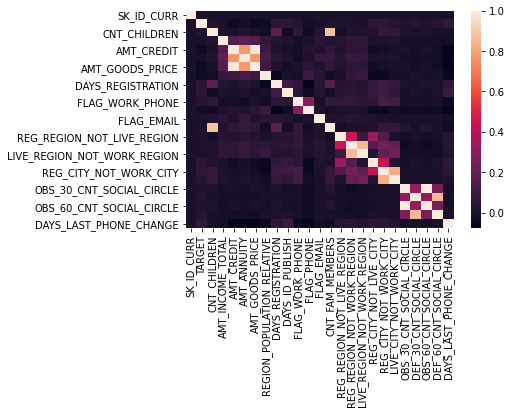

In [21]:
# Correlation heatmap before
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=False)
plt.show()

Then we drop all the features whose correlation is greater than 0.75.

In [22]:
# Drop features 
df = df.drop(df[to_drop], axis=1)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,...,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,Unaccompanied,...,0,WEDNESDAY,0,0,0,0,Business Entity Type 3,2.0,2.0,-1134.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,Family,...,0,MONDAY,0,0,0,0,School,1.0,0.0,-828.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Unaccompanied,...,0,MONDAY,0,0,0,0,Government,0.0,0.0,-815.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,Unaccompanied,...,0,WEDNESDAY,0,0,0,0,Business Entity Type 3,2.0,0.0,-617.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,Unaccompanied,...,0,THURSDAY,0,0,0,1,Religion,0.0,0.0,-1106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,Unaccompanied,...,0,THURSDAY,0,0,0,0,Services,0.0,0.0,-273.0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,Unaccompanied,...,0,MONDAY,0,0,0,0,XNA,0.0,0.0,0.0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,Unaccompanied,...,1,THURSDAY,0,0,0,1,School,6.0,0.0,-1909.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,Unaccompanied,...,0,WEDNESDAY,0,0,1,1,Business Entity Type 1,0.0,0.0,-322.0


We can see from the correlatioin heatmap after that there only white boxes on the diagonal.

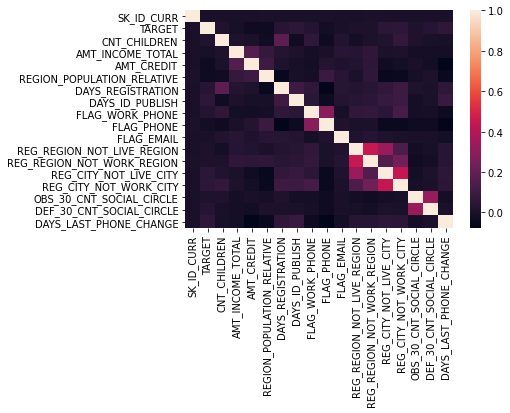

In [23]:
# Correlation Heatmap After
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=False)
plt.show()

### 3.4 Feature selection summary <a class="anchor" id="3.4"></a>
Now we are done with feature selection. We've dropped features with no meaning, features whose missing values > 10%, and highly-correlated features. To visualize the effects of processes we did, we plot a pie chart to see the distribution.

<img src="feature selection.jpeg" width="600">

## 4 Handling Missing Values  <a class="anchor" id="4"></a>
Now we are left with features whose missing values are less than 10%. To deal with the missing values, we intend to take two steps.

### 4.1 Create dichotomous dummy variable <a class="anchor" id="4.1"></a>
First, we will create a dichotomous dummy variable for each feature containing missing values. In the dummy variable, we will use 1 to indicate that the sample has a missing value in the corresponding feature and 0 otherwise. 

We fist print all the features with missing values.

In [24]:
# Create dichotomous dummy variable for features that have missing values
missing_perc = np.array(df.isna().mean().to_frame().iloc[:,0])
missing_col = df.columns[np.where(missing_perc > 0)]
missing_col

Index(['NAME_TYPE_SUITE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

Then we create the dichotomous dummy variable for these features and set the prefix as 'dummy_'.

In [25]:
# dichotomous dummy variable
for column in missing_col:
    df['dummy_{}'.format(column)] = df[column].isnull().astype(int)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,...,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,dummy_NAME_TYPE_SUITE,dummy_OBS_30_CNT_SOCIAL_CIRCLE,dummy_DEF_30_CNT_SOCIAL_CIRCLE,dummy_DAYS_LAST_PHONE_CHANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,Unaccompanied,...,0,0,Business Entity Type 3,2.0,2.0,-1134.0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,Family,...,0,0,School,1.0,0.0,-828.0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Unaccompanied,...,0,0,Government,0.0,0.0,-815.0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,Unaccompanied,...,0,0,Business Entity Type 3,2.0,0.0,-617.0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,Unaccompanied,...,0,1,Religion,0.0,0.0,-1106.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,Unaccompanied,...,0,0,Services,0.0,0.0,-273.0,0,0,0,0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,Unaccompanied,...,0,0,XNA,0.0,0.0,0.0,0,0,0,0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,Unaccompanied,...,0,1,School,6.0,0.0,-1909.0,0,0,0,0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,Unaccompanied,...,1,1,Business Entity Type 1,0.0,0.0,-322.0,0,0,0,0


### 4.2 Replace missing values <a class="anchor" id="4.2"></a>
After creating the dichotomous dummy variables, we replace all the missing values. We will deal with each data types seperately.

#### 4.2.1 Replace missing values for object type <a class="anchor" id="4.2.1"></a>
For missing values of object type, we replace them with mode, and encode the object type into int type using label encoder.

There is only one object feature with missing values.

In [26]:
# [Object] Missing columns for object type
obj_missing = np.array(df.select_dtypes('object').isna().mean().to_frame().iloc[:,0])
obj_missing_col = df.select_dtypes('object').columns[np.where(obj_missing > 0)] 
obj_missing_col

Index(['NAME_TYPE_SUITE'], dtype='object')

Then we replace the missing values with mode and encode it by label encoder in scikit learn.

In [27]:
# [Object] Replace missing values for object type using mode
le = LabelEncoder()
for column in df.select_dtypes('object').columns:
    df[column] = le.fit_transform(df[column].astype(str))
    df[column].fillna(df[column].mode()[0])
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,...,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,dummy_NAME_TYPE_SUITE,dummy_OBS_30_CNT_SOCIAL_CIRCLE,dummy_DEF_30_CNT_SOCIAL_CIRCLE,dummy_DAYS_LAST_PHONE_CHANGE
0,100002,1,0,1,0,1,0,202500.0,406597.5,6,...,0,0,5,2.0,2.0,-1134.0,0,0,0,0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,1,...,0,0,39,1.0,0.0,-828.0,0,0,0,0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6,...,0,0,11,0.0,0.0,-815.0,0,0,0,0
3,100006,0,0,0,0,1,0,135000.0,312682.5,6,...,0,0,5,2.0,0.0,-617.0,0,0,0,0
4,100007,0,0,1,0,1,0,121500.0,513000.0,6,...,0,1,37,0.0,0.0,-1106.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,1,0,0,0,157500.0,254700.0,6,...,0,0,43,0.0,0.0,-273.0,0,0,0,0
307507,456252,0,0,0,0,1,0,72000.0,269550.0,6,...,0,0,57,0.0,0.0,0.0,0,0,0,0
307508,456253,0,0,0,0,1,0,153000.0,677664.0,6,...,0,1,39,6.0,0.0,-1909.0,0,0,0,0
307509,456254,1,0,0,0,1,0,171000.0,370107.0,6,...,1,1,3,0.0,0.0,-322.0,0,0,0,0


#### 4.2.2 Replace missing values for int type <a class="anchor" id="4.2.2"></a>
The table below shows the missing values percentage of all int features. We can see from the table that there is no int features with missing values, so we skip this part.

In [28]:
# [Int] Replace Missing Value for int type (No missing value)
int_missing = np.array(df.select_dtypes('int').isna().mean().to_frame().iloc[:,0])
int_missing

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### 4.2.3 Replace missing values for float type <a class="anchor" id="4.2.3"></a>
There are two float features with missing values. We apply the nearest neighbor algorithm (1-NN) to impute missing values and fill the blanks. We use KNNImputer in scikit-learn.

There are two float features with missing values.

In [29]:
# [Float] Missing columns for float type
float_missing = np.array(df.select_dtypes('float').isna().mean().to_frame().iloc[:,0])
float_missing_col = df.select_dtypes('float').columns[np.where(float_missing > 0)]
float_missing_col

Index(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

We apply KNNImputer to imput missing float values.

In [30]:
# [Float] Replace Missing Value for float type by Nearest Neighbor 
imputer = KNNImputer(n_neighbors=1,copy=False)
df[float_missing_col] = imputer.fit_transform(df[float_missing_col])
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,...,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,dummy_NAME_TYPE_SUITE,dummy_OBS_30_CNT_SOCIAL_CIRCLE,dummy_DEF_30_CNT_SOCIAL_CIRCLE,dummy_DAYS_LAST_PHONE_CHANGE
0,100002,1,0,1,0,1,0,202500.0,406597.5,6,...,0,0,5,2.0,2.0,-1134.0,0,0,0,0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,1,...,0,0,39,1.0,0.0,-828.0,0,0,0,0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6,...,0,0,11,0.0,0.0,-815.0,0,0,0,0
3,100006,0,0,0,0,1,0,135000.0,312682.5,6,...,0,0,5,2.0,0.0,-617.0,0,0,0,0
4,100007,0,0,1,0,1,0,121500.0,513000.0,6,...,0,1,37,0.0,0.0,-1106.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,1,0,0,0,157500.0,254700.0,6,...,0,0,43,0.0,0.0,-273.0,0,0,0,0
307507,456252,0,0,0,0,1,0,72000.0,269550.0,6,...,0,0,57,0.0,0.0,0.0,0,0,0,0
307508,456253,0,0,0,0,1,0,153000.0,677664.0,6,...,0,1,39,6.0,0.0,-1909.0,0,0,0,0
307509,456254,1,0,0,0,1,0,171000.0,370107.0,6,...,1,1,3,0.0,0.0,-322.0,0,0,0,0


## 5 Introduce New Variables <a class="anchor" id="5"></a>
### 5.1 Introduce probability by income <a class="anchor" id="5.1"></a>
Intuitively, we think that income is one of the most important factors to predict whether or not the consumer has the ability to make credit card payment. Therefore, we introduce the loan default probability in each income range. We divide all the total annual incomes into 4 groups by order, and get the income range of each person. Then, we calculate the probability of default loans in each income range, and append the probability into the original dataset. The average rate of loan default in each level of income range would provide useful information to predict whether or not the person will default the loan.

We first sort all incomes and divide into quarters. Then we have a new column IncomeRange that represent which quarter they belong to.

In [31]:
df2 = df[['SK_ID_CURR','TARGET','AMT_INCOME_TOTAL']]
bins = [0, 1.125e+05, 1.4715e+05, 2.025000e+05, np.inf]
names = ['<25%', '25-50%', '50-75%', '>75%']
df2['IncomeRange'] = pd.cut(df2['AMT_INCOME_TOTAL'], bins, labels=names)
df2

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,IncomeRange
0,100002,1,202500.0,50-75%
1,100003,0,270000.0,>75%
2,100004,0,67500.0,<25%
3,100006,0,135000.0,25-50%
4,100007,0,121500.0,25-50%
...,...,...,...,...
307506,456251,0,157500.0,50-75%
307507,456252,0,72000.0,<25%
307508,456253,0,153000.0,50-75%
307509,456254,1,171000.0,50-75%


Then we calculate the probability of default in each income group.

In [32]:
df3 = df2.groupby(['IncomeRange', 'TARGET'])['TARGET'].size() / df2.groupby(['IncomeRange'])['TARGET'].size()
df3

IncomeRange  TARGET
<25%         0         0.916055
             1         0.083945
25-50%       0         0.914689
             1         0.085311
50-75%       0         0.916047
             1         0.083953
>75%         0         0.930904
             1         0.069096
Name: TARGET, dtype: float64

Then we append the probability by income group back to the dataframe.

In [33]:
df2 = pd.merge(df2, df3.rename('prob_by_income'), on=['IncomeRange','TARGET'], how='left')
df2

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,IncomeRange,prob_by_income
0,100002,1,202500.0,50-75%,0.083953
1,100003,0,270000.0,>75%,0.930904
2,100004,0,67500.0,<25%,0.916055
3,100006,0,135000.0,25-50%,0.914689
4,100007,0,121500.0,25-50%,0.914689
...,...,...,...,...,...
307506,456251,0,157500.0,50-75%,0.916047
307507,456252,0,72000.0,<25%,0.916055
307508,456253,0,153000.0,50-75%,0.916047
307509,456254,1,171000.0,50-75%,0.083953


In [34]:
df = pd.merge(df, df2[['SK_ID_CURR','prob_by_income']])
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,...,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,dummy_NAME_TYPE_SUITE,dummy_OBS_30_CNT_SOCIAL_CIRCLE,dummy_DEF_30_CNT_SOCIAL_CIRCLE,dummy_DAYS_LAST_PHONE_CHANGE,prob_by_income
0,100002,1,0,1,0,1,0,202500.0,406597.5,6,...,0,5,2.0,2.0,-1134.0,0,0,0,0,0.083953
1,100003,0,0,0,0,0,0,270000.0,1293502.5,1,...,0,39,1.0,0.0,-828.0,0,0,0,0,0.930904
2,100004,0,1,1,1,1,0,67500.0,135000.0,6,...,0,11,0.0,0.0,-815.0,0,0,0,0,0.916055
3,100006,0,0,0,0,1,0,135000.0,312682.5,6,...,0,5,2.0,0.0,-617.0,0,0,0,0,0.914689
4,100007,0,0,1,0,1,0,121500.0,513000.0,6,...,1,37,0.0,0.0,-1106.0,0,0,0,0,0.914689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,1,0,0,0,157500.0,254700.0,6,...,0,43,0.0,0.0,-273.0,0,0,0,0,0.916047
307507,456252,0,0,0,0,1,0,72000.0,269550.0,6,...,0,57,0.0,0.0,0.0,0,0,0,0,0.916055
307508,456253,0,0,0,0,1,0,153000.0,677664.0,6,...,1,39,6.0,0.0,-1909.0,0,0,0,0,0.916047
307509,456254,1,0,0,0,1,0,171000.0,370107.0,6,...,1,3,0.0,0.0,-322.0,0,0,0,0,0.083953


### 5.2 Introduce previously approved probability <a class="anchor" id="5.2"></a>

We also introduce previously appproved loans probability, which is derived from table previous_application. Since previous_application contains several past loan records for each person, some of which are approved, some of which are cancelld or refused. We calculate the percentage of previous loans that are approved, and join the percentage with original dataset by SK_ID_CURR. The probability of approved previous loans would also provide useful information to predict whether or not the person will default the loan.

Below is the previously approved probability for each SK_ID_CURR in previous_application.

In [35]:
# Introduce new variable from previous data: Percentage of approved loan in the past
result = pre_df.groupby(['SK_ID_CURR','NAME_CONTRACT_STATUS'])['SK_ID_CURR'].size() / pre_df.groupby(['SK_ID_CURR'])['SK_ID_CURR'].size()
result.rename('PREV_APPROVED_PROB').to_csv('prob.csv')
prob = pd.read_csv('prob.csv')
prob.iloc[0:10,:]

,SK_ID_CURR,NAME_CONTRACT_STATUS,PREV_APPROVED_PROB
0,100001,Approved,1.000000
1,100002,Approved,1.000000
2,100003,Approved,1.000000
3,100004,Approved,1.000000
4,100005,Approved,0.500000
5,100005,Canceled,0.500000
6,100006,Approved,0.555556
7,100006,Canceled,0.333333
8,100006,Refused,0.111111
9,100007,Approved,1.000000


In [36]:
approved_df = prob[prob['NAME_CONTRACT_STATUS']=='Approved']
approved_df = approved_df[['SK_ID_CURR','PREV_APPROVED_PROB']]
approved_df

,SK_ID_CURR,PREV_APPROVED_PROB
0,100001,1.00
1,100002,1.00
2,100003,1.00
3,100004,1.00
4,100005,0.50
...,...,...
610742,456251,1.00
610743,456252,1.00
610744,456253,1.00
610745,456254,1.00


Then we merge the previously approved probability back to the dataframe.

In [37]:
df = pd.merge(df, approved_df, on=['SK_ID_CURR'], how='left')
df['PREV_APPROVED_PROB'] = df['PREV_APPROVED_PROB'].fillna(0)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,...,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,dummy_NAME_TYPE_SUITE,dummy_OBS_30_CNT_SOCIAL_CIRCLE,dummy_DEF_30_CNT_SOCIAL_CIRCLE,dummy_DAYS_LAST_PHONE_CHANGE,prob_by_income,PREV_APPROVED_PROB
0,100002,1,0,1,0,1,0,202500.0,406597.5,6,...,5,2.0,2.0,-1134.0,0,0,0,0,0.083953,1.000000
1,100003,0,0,0,0,0,0,270000.0,1293502.5,1,...,39,1.0,0.0,-828.0,0,0,0,0,0.930904,1.000000
2,100004,0,1,1,1,1,0,67500.0,135000.0,6,...,11,0.0,0.0,-815.0,0,0,0,0,0.916055,1.000000
3,100006,0,0,0,0,1,0,135000.0,312682.5,6,...,5,2.0,0.0,-617.0,0,0,0,0,0.914689,0.555556
4,100007,0,0,1,0,1,0,121500.0,513000.0,6,...,37,0.0,0.0,-1106.0,0,0,0,0,0.914689,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,1,0,0,0,157500.0,254700.0,6,...,43,0.0,0.0,-273.0,0,0,0,0,0.916047,1.000000
307507,456252,0,0,0,0,1,0,72000.0,269550.0,6,...,57,0.0,0.0,0.0,0,0,0,0,0.916055,1.000000
307508,456253,0,0,0,0,1,0,153000.0,677664.0,6,...,39,6.0,0.0,-1909.0,0,0,0,0,0.916047,1.000000
307509,456254,1,0,0,0,1,0,171000.0,370107.0,6,...,3,0.0,0.0,-322.0,0,0,0,0,0.083953,1.000000


At this point, we are done with all preprocessing steps. We perform a final check that there is no missing values in the dataset.

In [38]:
# Check no missing value
df.isna().mean().to_frame().iloc[:,0]

SK_ID_CURR                        0.0
TARGET                            0.0
NAME_CONTRACT_TYPE                0.0
CODE_GENDER                       0.0
FLAG_OWN_CAR                      0.0
FLAG_OWN_REALTY                   0.0
CNT_CHILDREN                      0.0
AMT_INCOME_TOTAL                  0.0
AMT_CREDIT                        0.0
NAME_TYPE_SUITE                   0.0
NAME_INCOME_TYPE                  0.0
NAME_EDUCATION_TYPE               0.0
NAME_FAMILY_STATUS                0.0
NAME_HOUSING_TYPE                 0.0
REGION_POPULATION_RELATIVE        0.0
DAYS_REGISTRATION                 0.0
DAYS_ID_PUBLISH                   0.0
FLAG_WORK_PHONE                   0.0
FLAG_PHONE                        0.0
FLAG_EMAIL                        0.0
WEEKDAY_APPR_PROCESS_START        0.0
REG_REGION_NOT_LIVE_REGION        0.0
REG_REGION_NOT_WORK_REGION        0.0
REG_CITY_NOT_LIVE_CITY            0.0
REG_CITY_NOT_WORK_CITY            0.0
ORGANIZATION_TYPE                 0.0
OBS_30_CNT_S

We save the cleaned data into a csv file.

In [39]:
df.to_csv('cleaned_data.csv')

## 6 Prepare for Training <a class="anchor" id="6"></a>
### 6.1 Extract $X$ and $y$ <a class="anchor" id="6.1"></a>
The final input matrix $X$ is the original input matrix gone through all the transformations described above, with each row represents a client and each column represents a feature. The target variable $y$ is a binary variable indicating whether the client will have difficulty to make timely payments.

The cleaned dataset has 307510 samples in total, and the feature matrix has 32 columns.

In [40]:
feature_names = df.columns[2:]
df = df.to_numpy()
y = df[:,1]
y

array([1., 0., 0., ..., 0., 1., 0.])

In [41]:
X = df[:,2:]
X

array([[0.        , 1.        , 0.        , ..., 0.        , 0.08395266,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.93090386,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.9160552 ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.91604734,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.08395266,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.91604734,
        0.75      ]])

### 6.2 Split the train-test sets <a class="anchor" id="6.2"></a>
The training set has 80% data, while the test set has the remaining 20%.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### 6.3 Normalization <a class="anchor" id="6.3"></a>
Separate normalization ensures the information contained in the test set will not be leaked to the training set.

In [43]:
# Normalize training set
scaler_train = preprocessing.StandardScaler()
scaler_train.fit(X_train)
X_train = scaler_train.transform(X_train)

# Normalize test set
scaler_test = preprocessing.StandardScaler()
scaler_test.fit(X_test)
X_test = scaler_test.transform(X_test)

## 7 Check PCA <a class="anchor" id="7"></a>
When pre-processing the dataset, we found it took significant amount of time to run the k-NN algorithm for missing value imputation due to the size and dimension of the dataset. Therefore, we will conduct a Principal Component Analysis (PCA) here to check if the dimension of the dataset can be reduced. We also plot the total variance explained by each component below.

(0.0, 0.8)

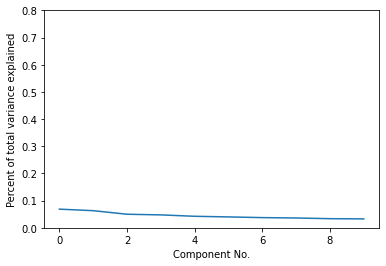

In [44]:
pca = PCA(n_components=10)
pca.fit(X_train)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Component No.')
plt.ylabel('Percent of total variance explained')
plt.ylim([0, 0.8])

Since each components only explains a small amount of total variance, PCA does not help here to compress the dataset. Therefore, we will continue using the whole feature columns.

## 8 Treating Imbalanced Data <a class="anchor" id="8"></a>
Let first take a look at the distribution of the target variable.

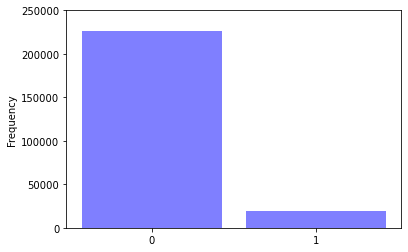

[(0.0, 226198), (1.0, 19810)]


In [45]:
plt.hist(y_train, bins = [-.5,.5,1.5], facecolor='blue', alpha=0.5, rwidth=0.85)
plt.xticks((0,1))
plt.ylim(0, 250000)
plt.ylabel('Frequency')
plt.show()
print(sorted(Counter(y_train).items()))

We see the negative class is about 11X of the positive class. A highly imbalanced dataset may cause classifiers to over-favor the majority class and are more likely to give negative predictions than positive ones. We will handle this in the following steps.

### 8.1 K-NN under-sampling <a class="anchor" id="8.1"></a>

The technique of under-sampling serves to reduce the size of the majority (negative) class. A naive approach is the random under-sampling, which randomly remove samples from the majority class. This approach might be defective, as it may remove valuable information contained in negative samples. So in our approach, for each negative sample, we will use the 1-NN algorithm to find and remove its nearest neighbor. We believe this approach has the advantage of reducing the class size while keeping information in the negative samples as much as possible. We will remove 25% of negative samples in total.

Note: This part may take several minutes.

In [46]:
neigh = NearestNeighbors(n_neighbors=2, n_jobs=-1)
neigh.fit(X_train)
size = int(X_train[y_train==0].shape[0]/4)
nearest = neigh.kneighbors(X_train[1:size, :])[1][:, 1]
nearest = nearest[y_train[nearest]==0]
X_resampled = np.delete(X_train, nearest, axis=0)
y_resampled = np.delete(y_train, nearest, axis=0)

After under-sampling:

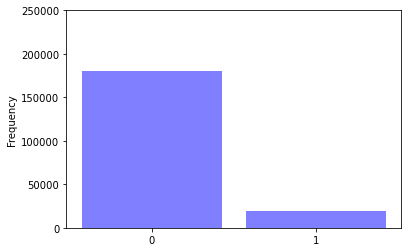

[(0.0, 180202), (1.0, 19810)]


In [47]:
plt.hist(y_resampled, bins = [-.5,.5,1.5], facecolor='blue', alpha=0.5, rwidth=0.85)
plt.xticks((0,1))
plt.ylabel('Frequency')
plt.ylim(0, 250000)
plt.show()
print(sorted(Counter(y_resampled).items()))

### 8.2 Random Over-Sampling <a class="anchor" id="8.2"></a>
The technique of over-sampling serves to increase the size of the minority (positive) class. Using random over-sampling, we will randomly select samples from the positive class with replacement, duplicate them, and add them back to the training set. After over-sampling, the negative class is about 2X of the positive class.

After over-sampling:

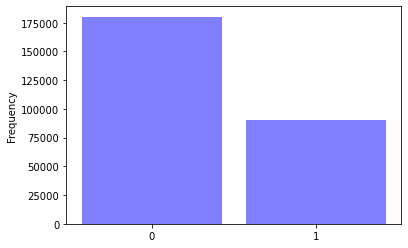

[(0.0, 180202), (1.0, 90101)]


In [48]:
rs = RandomOverSampler(random_state=0, sampling_strategy=0.5)
X_res, y_res = rs.fit_resample(X_resampled, y_resampled)
plt.hist(y_res, bins = [-.5,.5,1.5], facecolor='blue', alpha=0.5, rwidth=0.85)
plt.xticks((0,1))
plt.ylabel('Frequency')
plt.show()
print(sorted(Counter(y_res).items()))

### 8.3 Sampling summary <a class="anchor" id="8.3"></a>
To better visualize how we deal with the imbalanced data and the effect of sampling, we plot the histogram of defaults and non-defualts after knn under sampling and random over sampling. 

<img src="sampling.jpeg" width="800">


## 9 Loss Function and Build the Models <a class="anchor" id="9"></a>

Generally, both logistic regression and decision tree models will try to maximize the log-likelihood loss function

$L(f)=\sum_{X_i}y_i\log f(X_i)+(1-y_i)\log (1-f(X_i))$

where $X_i$ represents a sample, $y_i$ is the value of its target variable, and the function $f$ is the classification model. The standard log-likelihood loss function is based on an implicit assumption that the positive class and negative class have equal importance. 

However, we believe this loss function may not be appropriate in our case. This is because for banks, the magnitude of loss caused by a client's default is usually much greater than the profit. Consider the situation where a bank sanctions an $\$100$ loan to a client. If the client pays back the loan in time, then the bank may only gain $\$10$ profit; but if the client defaults, then the bank is very likely to incur a loss at nearly $\$100$.

Therefore, we believe that the positive class should carry more weight than the negative class. Banks can tolerate more false positives (declining the application of a client that is not likely to default) than false negatives (sanctioning a loan to a client that is likely to default). Based on this, we decide to give more weight to the positive class in the loss function (3:1).


### 9.1 Logistic regression model <a class="anchor" id="9.1"></a>

In [49]:
clf = LogisticRegression(random_state=0, class_weight = {0:1, 1:3}).fit(X_res, y_res)
y_pred_lf = clf.predict(X_test)

### 9.2 Random forest model <a class="anchor" id="9.2"></a>

In [50]:
rf = RandomForestClassifier(random_state=0, class_weight = {0:1, 1:3}).fit(X_res, y_res)
y_pred_rf = rf.predict(X_test)

## 10 Evaluation <a class="anchor" id="10"></a>
Common evaluation metrics for evaluating classification tasks include accuracy, precision, recall, ROC curve, and the AUROC score. As the data set we use is highly imbalanced with the majority target variable being negative and only a few positive cases, we believe accuracy is not appropriate to evaluate our model.

Consider an extreme case where we have $100$ samples in total, and $99$ of them are negative. If accuracy = $\frac{TP+TN}{P+N}$ is used to measure the performance of a model, a model which classifies all samples as negative will achieve an extraordinary accuracy ($99\%$). But it is quite obvious that this model is not good and will not provide us with any valuable information. Therefore, we will not use accuracy to evaluate our model.

As a result, our evaluation metrics will include the ROC curve and AUROC score, which reflect the relation between the TPR and FPR, precision, which reflects the percentage of positive classifications that are true positive, and recall, which reflects the percentage of positive samples that are correctly classified.

The function below is used to evaluate the performance of a model. The function takes the predicted values "y_pred" and the actual values "y_test" as the input, and then it will print the confusion matrix, the precision and recall score, and plot the ROC curve with the AUROC score.

In [51]:
def evaluate(y_test, y_pred):
    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print("AUROC: ",auc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print("(tn, fp, fn, tp): ", (tn, fp, fn, tp))
    print("precision: ", precision)
    print("recall: ", recall)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

### 10.1 Evaluate logistic regression model <a class="anchor" id="10.1"></a>

AUROC:  1.0
(tn, fp, fn, tp):  (56488, 0, 0, 5015)
precision:  1.0
recall:  1.0


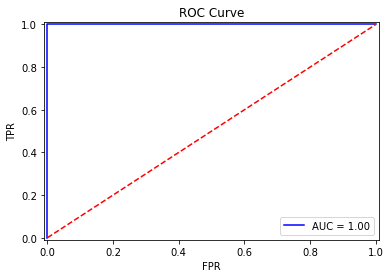

In [52]:
evaluate(y_test, y_pred_lf)

### 10.2 Evaluate random forest model <a class="anchor" id="10.2"></a>

AUROC:  1.0
(tn, fp, fn, tp):  (56488, 0, 0, 5015)
precision:  1.0
recall:  1.0


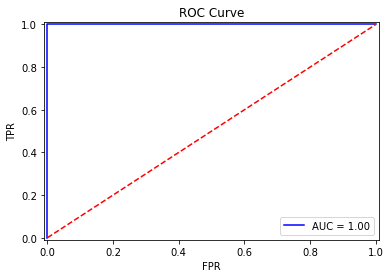

In [53]:
evaluate(y_test, y_pred_rf)

Our model has achieved a outstanding performance in classifying  the loans that are likely to default. Both logistic regression and random forest model have a perfect ROC curve and AUROC score with no misclassification. So the precision and recall score are 1 for both models.

To better investigate what leads to the outstanding model performance, we decide to conduct the steps below with regard to feature importance and model comparison.

## 11 Feature Importance <a class="anchor" id="11"></a>


In addition to building a loan default prediction model, we also want to find the top driving variables (i.e. the most important feature underlying a loan default). As we have built a random forest model, here we will use mean decrease in impurity (MDI) to examine the feature importance. According to the manual of the scikit-learn package, MDI in is calculated as "the total decrease in node impurity, weighted by the proportion of samples reaching that node, and averaged by the number of trees in the random forest". The results are shown below:

Features sorted by their score:


Text(0.5, 1.0, 'Random Forest Feature Importances (MDI)')

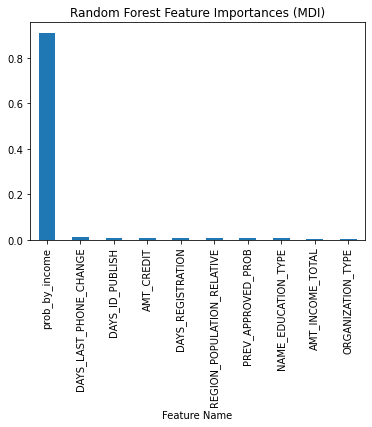

In [54]:
print("Features sorted by their score:")
feature_importance = sorted(zip(map(lambda x:round(x,4), rf.feature_importances_),
                                feature_names),reverse = True)
feature_importance_dataframe = pd.DataFrame(feature_importance, 
                                            columns = ['Importance', 'Feature Name'])
top_ten_feature = feature_importance_dataframe.head(10)
plot = top_ten_feature.plot.bar(x = 'Feature Name', y = 'Importance', legend = False)
plot.set_title('Random Forest Feature Importances (MDI)')

In the figure above, we can see the feature "prob_by_income" accounts for over 90% of total feature importance, while the remaining 30 features have very low importance. It is worthwhile to note here that this feature is manually created during our feature engineering process used to indicate the default probability for different income groups.

As a comparison, in the step below, we will build another logistic regression model on the same dataset but without the new feature "prob_by_income" or treating the imbalance. The new dataset has everything the same, except missing one feature and applying over-sampling & under-sampling techniques.

## 12 Comparing with the model without feature engineering or treating imbalance <a class="anchor" id="12"></a>
The new dataset is created from the old one by removing the "prob_by_income" feature (located in the second to last column).

In [55]:
X_cmp_train = np.delete(X_train, -2, axis=1)
X_cmp_test = np.delete(X_test, -2, axis=1)
y_cmp_train = y_train
y_cmp_test = y_test

AUROC:  0.5
(tn, fp, fn, tp):  (56488, 0, 5015, 0)
precision:  nan
recall:  0.0


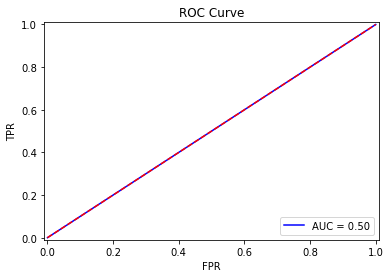

In [56]:
clf_cmp = LogisticRegression(random_state=0).fit(X_cmp_train, y_cmp_train)
y_cmp_pred = clf_cmp.predict(X_cmp_test)
evaluate(y_cmp_test, y_cmp_pred)

The evaluation results indicate that the model without our manually engineered feature has very high false negative rate and a very low recall score. The precision score is "nan" here, as the model has incorrectly classified all testing samples as negative due to the high imbalance between two classes. The ROC chart, together with the AUROC score, shows that the model performance is just the same as random guessing. Therefore, compared to the model having gone through feature engineering and imbalance treatment, this baseline model results in significantly lower performance. If a bank uses this model for loan sanction purpose, it is likely to lose a great deal of money for the large probability of clients' defaults.

## 13 Conclusion <a class="anchor" id="13"></a>

This report mainly discusses and confirms the importance of feature engineering and imbalance treatment for a highly imbalanced loan default dataset. In the pre-processing step, in addition to the standard processes like normalization and missing value imputation, we have also taken some unique steps such as adding dummy variables indicating the presence of missing values and creating new features based on the patterns of existing ones. We have also conducted a PCA analysis on the feature matrix to check if the dimensionality can be reduced.

When treating the imbalance within the dataset, we have applied both the techniques of over-sampling and under-sampling to reduce the disparity while minimizing the loss of information. We also assigned different weights to the two classes in the loss function for a further decrease of the imbalance.

In conclusion, our results indicate the model gone through all those processes have significantly higher performance than the baseline model without feature engineering and imbalance treatment. Also, the new variable we introduced using previous data turns out to be the most important factor for banks to determine whether or not a loan will be defaulted.